In [1]:
# This is the analysis notebook for the first submission of the VOGM 4D flow manuscript
# Jeff Stout, Boston Children's Hospital
# 2024/01/29

# These commands are useful for stitching together the figures:
# montage fig3a_excld12.png fig3b_excld12.png fig3c_excld12.png fig3d_excld12.png fig3e_excld12.png fig3f_excld12.png fig3g_excld12.png fig3h_excld12.png -tile 2x -geometry +0+0 Fig3.png

# montage fig4a_excld12.png fig4b_excld12.png fig4c_excld12.png fig4d_excld12.png -geometry +0+0 Fig4.png

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import json
import nibabel as nib
import nilearn
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy
import scipy.stats
import scipy.io
import nilearn.image
import nilearn.glm
import nilearn.plotting
import statsmodels.stats.multitest

In [3]:
T = pd.read_csv('VOGM_4dflowdata.csv')

T['SSMD'] = T['SS-MD']
T['SSA'] = T['SS-A']
T['inflow_ml/min'] = T['Inflow']*60
T['age_at_scan_weeks'] = T['age_at_scan_months']* (52/12)

# Don't always have SSS from the same technqiue, standardize to 2D PCMRI
T['SSS'] = T['SSS_pre_2dpcmri']

# Can use the 4D flow to replace missing data, if helpful
# T.loc[1, 'SSS'] =  T.loc[1, 'SSS_pre_4dflow']
# T.loc[4, 'SSS'] =  T.loc[4, 'SSS_pre_4dflow']
# T.loc[11, 'SSS'] =  T.loc[11, 'SSS_pre_4dflow']
# T.loc[15, 'SSS'] =  T.loc[15, 'SSS_pre_4dflow']

# Drop unsedated subject 12 from further analysis
T = T[T['ID_N'] != 12]

T = T.reset_index()

In [29]:
# T[['ID_N', 'age_at_scan_months', 'SSS_mlmin']]

,ID_N,age_at_scan_months,SSS_mlmin
0,1,14.133333,264.0
1,2,5.500000,NaN
2,3,2.566667,14.4
3,3,2.900000,52.8
4,4,5.533333,NaN
5,5,3.900000,130.8
6,6,0.033333,33.6
7,7,0.200000,24.0
8,8,4.833333,59.4
9,9,4.466667,-10.2


In [5]:
# There are two groups here and the embo for some definitely affects flow
# the slopes are about the same, different intercepts, none signficant.
# Joint modeling would be possible.

T_noembo = T[T.embo == 0].reset_index(drop=True)


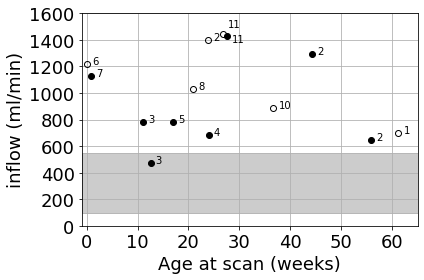

In [6]:
##### Figure 3a
# Inflow versus GA. This is really abnormal
# So this is an interesting plot when compared with the normal data that goes from 100ml/min at birth to 550ml/min at 60 weeks (ref: Varela, Liu)
# plt.plot(T['age_at_scan_weeks'], T['inflow_ml/min'], 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'inflow_ml/min'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'inflow_ml/min'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('inflow (ml/min)', fontsize=18)
plt.ylim([0, 1600])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
ax = plt.gca()
ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i]+0.1)))
    
for i, x in enumerate(T['ID_N']):
    if x != 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i])))
for i, x in enumerate(T['ID_N']):
    if x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i])+50))
    if x == 11 and i == 12:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i])-50))

fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig3a_excld12.png')  

In [36]:
f'Inflow is {np.mean(T["inflow_ml/min"])} +/- {np.std(T["inflow_ml/min"])}'

'Inflow is 1062.88 +/- 403.3439544607059'

In [33]:
np.std(T['inflow_ml/min'])

403.3439544607059

In [7]:
# Helper function to format the statmodels output for direct copy into the results table
def format_result(result):
    output = ""
    for name in result.model.exog_names:
        coef = result.params.loc[name] # Get the coefficient estimate
        lower = result.conf_int().loc[name, 0] # Get the lower limit of the confidence interval
        upper = result.conf_int().loc[name, 1] # Get the upper limit of the confidence interval
        pvalue = result.pvalues.loc[name] # Get the p-value
        # Format the output as "name: coef [lower, upper] pvalue ="
        output += f"{name}: {coef:.0f} [{lower:.0f}, {upper:.0f}] P={pvalue:.3f}\n"
    SW = scipy.stats.shapiro(result.resid)
    output += f"W={SW.statistic:.2f}, P={SW.pvalue:.3f}"
    return output

                            OLS Regression Results                            
Dep. Variable:          inflow_ml_min   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.4799
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.501
Time:                        09:57:13   Log-Likelihood:                -111.01
No. Observations:                  15   AIC:                             226.0
Df Residuals:                      13   BIC:                             227.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1175.4963    196.20

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


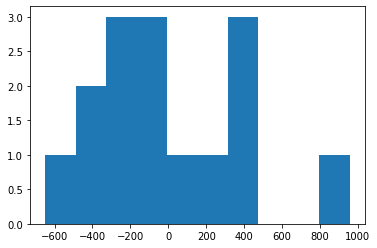

Intercept: 1175 [752, 1599] P=0.000
age_at_scan_weeks: -4 [-18, 9] P=0.501
W=0.95, P=0.465
                            OLS Regression Results                            
Dep. Variable:          inflow_ml_min   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     1.824
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.203
Time:                        09:57:14   Log-Likelihood:                -109.29
No. Observations:                  15   AIC:                             224.6
Df Residuals:                      12   BIC:                             226.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


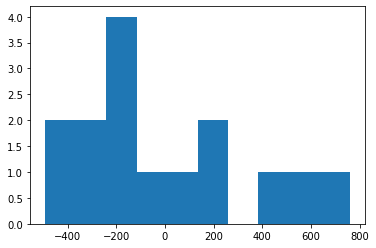

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept: 1390 [912, 1867] P=0.000
age_at_scan_weeks: -5 [-18, 8] P=0.391
embo: -361 [-807, 86] P=0.104
W=0.92, P=0.168
                            OLS Regression Results                            
Dep. Variable:          inflow_ml_min   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.124
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.382
Time:                        09:57:14   Log-Likelihood:                -109.28
No. Observations:                  15   AIC:                             226.6
Df Residuals:                      11   BIC:                             229.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---

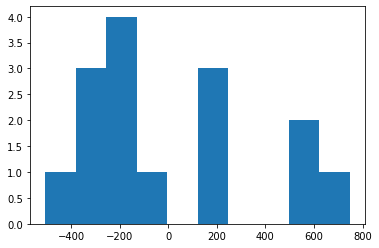

Intercept: 1414 [785, 2044] P=0.000
age_at_scan_weeks: -6 [-23, 11] P=0.452
embo: -363 [-836, 110] P=0.119
NAR: -55 [-896, 786] P=0.889
W=0.92, P=0.199


In [8]:
# Inflow models for paper
T['inflow_ml_min'] = T['inflow_ml/min']
mod = smf.ols(formula="inflow_ml_min ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="inflow_ml_min ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="inflow_ml_min ~ age_at_scan_weeks + embo + NAR", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

In [9]:
# What is cortical flow? something like the inflow - varix flow
T['cortical_flow'] = (T['Inflow'] - T['falcine'])*60
# Or it could be SSS flow before the falcine drainage
T['SSS_mlmin'] = T['SSS'] * 60

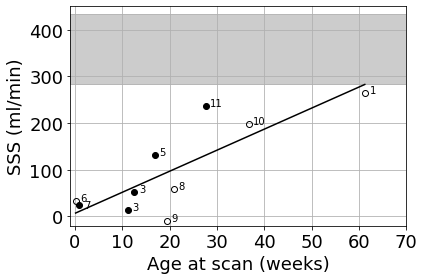

In [10]:
## SSS versus GA. Fig 2d

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'SSS_mlmin'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'SSS_mlmin'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('SSS (ml/min)', fontsize=18)
plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# Trendline
T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
f = np.poly1d(d)
plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
plt.plot(plot_x, f(plot_x), 'k-')

ax = plt.gca()
# ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if x == 7: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['SSS_mlmin'][i]-6))
    elif x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['SSS_mlmin'][i]-6))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['SSS_mlmin'][i]))

# SSS from Can Wu
sss_data = pd.read_excel('/home/jeff/jeff.stout/research/clinical_cases/ISMRM2023/Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
plt.xlim([-1, 70])
plt.ylim([-20, 450])
ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig4d_excld12.png')

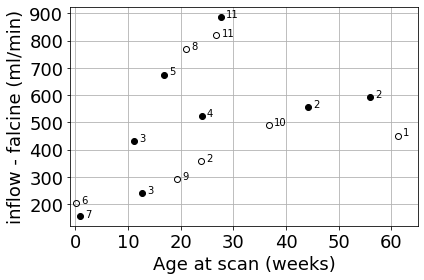

In [11]:
## Inflow-flacine versus GA. fig 2c

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'cortical_flow'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'cortical_flow'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('inflow - falcine (ml/min)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['cortical_flow'], 1)
# f = np.poly1d(d)
# plt.plot(T_nan['age_at_scan_weeks'], f(T_nan['age_at_scan_weeks']), 'k-')

ax = plt.gca()
# ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if x == 7: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['cortical_flow'][i]-6))
    elif x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['cortical_flow'][i]-6))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['cortical_flow'][i]))

        
fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig3b_excld12.png')

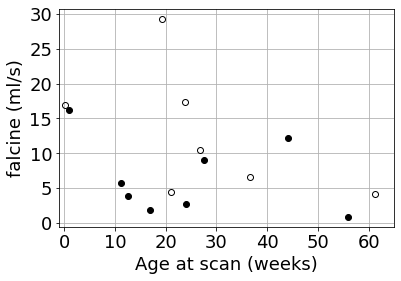

In [12]:
## Inflow-flacine versus GA

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'falcine'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'falcine'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('falcine (ml/s)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()


                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     8.274
Date:                Thu, 15 Feb 2024   Prob (F-statistic):             0.0130
Time:                        09:57:14   Log-Likelihood:                -109.28
No. Observations:                  15   AIC:                             222.6
Df Residuals:                      13   BIC:                             224.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -205.9810    285.786     -0.721      0.4

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


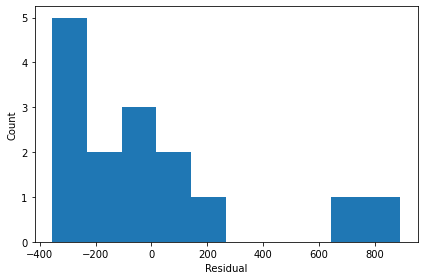

Intercept: -206 [-823, 411] P=0.484
SSMD: 151 [37, 264] P=0.013
W=0.79, P=0.003
                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     10.58
Date:                Thu, 15 Feb 2024   Prob (F-statistic):            0.00225
Time:                        09:57:14   Log-Likelihood:                -105.36
No. Observations:                  15   AIC:                             216.7
Df Residuals:                      12   BIC:                             218.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


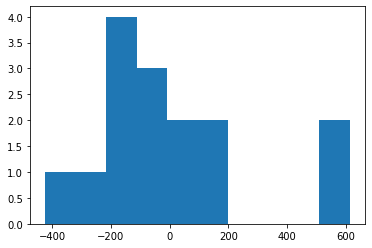

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept: -49 [-562, 463] P=0.837
SSMD: 168 [75, 260] P=0.002
embo: -456 [-802, -110] P=0.014
W=0.91, P=0.134
                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     7.362
Date:                Thu, 15 Feb 2024   Prob (F-statistic):            0.00560
Time:                        09:57:14   Log-Likelihood:                -104.72
No. Observations:                  15   AIC:                             217.4
Df Residuals:                      11   BIC:                             220.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

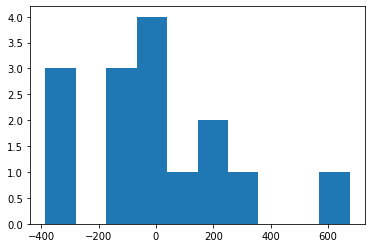

Intercept: -23 [-545, 499] P=0.926
SSMD: 155 [58, 252] P=0.005
embo: -446 [-796, -95] P=0.017
NAR: 238 [-293, 769] P=0.345
W=0.94, P=0.379
                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1.925
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.189
Time:                        09:57:14   Log-Likelihood:                -111.94
No. Observations:                  15   AIC:                             227.9
Df Residuals:                      13   BIC:                             229.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.0

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


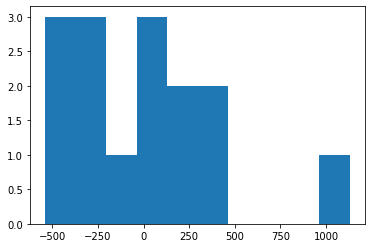

Intercept: 806 [355, 1257] P=0.002
age_at_scan_weeks: -9 [-24, 5] P=0.189
W=0.91, P=0.151
                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     2.842
Date:                Thu, 15 Feb 2024   Prob (F-statistic):             0.0976
Time:                        09:57:15   Log-Likelihood:                -110.07
No. Observations:                  15   AIC:                             226.1
Df Residuals:                      12   BIC:                             228.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


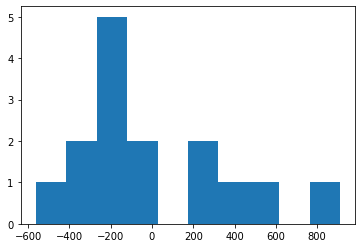

Intercept: 1043 [540, 1546] P=0.001
age_at_scan_weeks: -10 [-24, 3] P=0.123
embo: -399 [-869, 72] P=0.090
W=0.93, P=0.273


In [13]:
# Falcine models

T['falcine_mlmin'] = T['falcine'] * 60

mod = smf.ols(formula="falcine_mlmin ~ SSMD", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.xlabel('Residual')
plt.ylabel('Count')
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('fig4b_excld12.png')

print(format_result(res))

mod = smf.ols(formula="falcine_mlmin ~ SSMD + embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin ~ SSMD + embo + NAR", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin ~ age_at_scan_weeks", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin ~ age_at_scan_weeks +embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

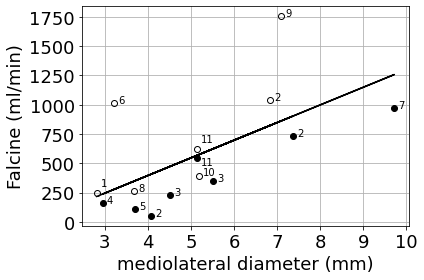

In [14]:
### Figure 2b (raw flow)
# Falcince:Inflow versus SS-MD. This is really abnormal
# So this is an interesting plot when compared with the normal data that goes from 100ml/min at birth to 550ml/min at 60 weeks (ref: Varela, Liu)
# abstract style, all solid
# plt.plot(T['SS-MD'], T['falcine']*60, 'ko')

# # No red/black for NAR, ALL Black
# # No NAR is black
# plt.plot(T.loc[(T['embo']==0) , 'SS-MD'], T.loc[(T['embo']==0) , 'falcine']*60, 'ko', fillstyle='none',)
# plt.plot(T.loc[(T['embo']==1) , 'SS-MD'], T.loc[(T['embo']==1) , 'falcine']*60, 'ko')

# No NAR is black
plt.plot(T.loc[(T['embo']==0) & (T['NAR']==0), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==0), 'falcine']*60, 'ko', fillstyle='none',)
plt.plot(T.loc[(T['embo']==1) & (T['NAR']==0), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==0), 'falcine']*60, 'ko')
# NAR is red
# plt.plot(T.loc[(T['embo']==0) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==1), 'falcine']*60, 'ro', fillstyle='none',)
# plt.plot(T.loc[(T['embo']==1) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==1), 'falcine']*60, 'ro')
plt.plot(T.loc[(T['embo']==0) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==1), 'falcine']*60, 'ko', fillstyle='none',)
plt.plot(T.loc[(T['embo']==1) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==1), 'falcine']*60, 'ko')

plt.xlabel('mediolateral diameter (mm)', fontsize=18)
plt.ylabel('Falcine (ml/min)', fontsize=18)
# plt.ylim([0, 300])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
d = np.polyfit(T['SS-MD'], T['falcine']*60, 1)
f = np.poly1d(d)
plt.plot(T['SS-MD'], f(T['SS-MD']), 'k-')
 
for i, x in enumerate(T['ID_N']):
    if i == 0:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine'][i]+1)*60))
    elif i == 11:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine'][i]+1)*60))
    elif i == 12:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine'][i]-1)*60))
    else:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, T['falcine'][i]*60))

# # M.W. second time point
# plt.plot(4.52, 3.8, 'ko', fillstyle='none')
# plt.annotate('3', (4.52+0.1, 3.8+0.1))

fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig4a_excld12.png')

                            OLS Regression Results                            
Dep. Variable:     falcine_mlmin_root   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     9.281
Date:                Thu, 15 Feb 2024   Prob (F-statistic):            0.00936
Time:                        09:57:15   Log-Likelihood:                -17.363
No. Observations:                  15   AIC:                             38.73
Df Residuals:                      13   BIC:                             40.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7873      0.623      4.472      0.0

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


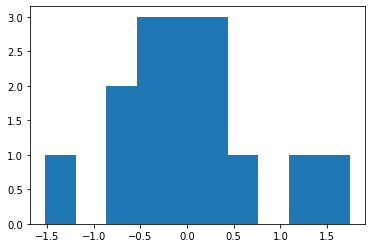

Intercept: 2.79 [1.44, 4.13] P=0.001
SSMD: 0.35 [0.10, 0.59] P=0.009
W=0.97, P=0.817
                            OLS Regression Results                            
Dep. Variable:     falcine_mlmin_root   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     13.53
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           0.000842
Time:                        09:57:15   Log-Likelihood:                -12.554
No. Observations:                  15   AIC:                             31.11
Df Residuals:                      12   BIC:                             33.23
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


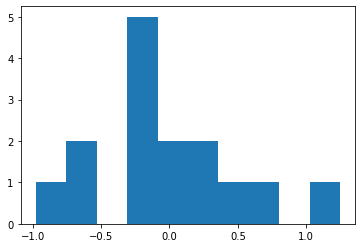

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept: 3.16 [2.10, 4.21] P=0.000
SSMD: 0.39 [0.20, 0.58] P=0.001
embo: -1.07 [-1.78, -0.36] P=0.007
W=0.98, P=0.969
                            OLS Regression Results                            
Dep. Variable:     falcine_mlmin_root   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     10.04
Date:                Thu, 15 Feb 2024   Prob (F-statistic):            0.00176
Time:                        09:57:15   Log-Likelihood:                -11.514
No. Observations:                  15   AIC:                             31.03
Df Residuals:                      11   BIC:                             33.86
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

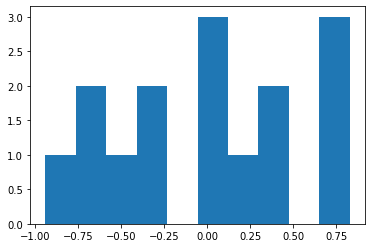

Intercept: 3.22 [2.18, 4.27] P=0.000
SSMD: 0.36 [0.16, 0.55] P=0.002
embo: -1.04 [-1.75, -0.34] P=0.007
NAR: 0.62 [-0.45, 1.68] P=0.227
W=0.97, P=0.849


In [15]:
# Falcine models
# fourth root

# Helper function to format the statmodels output for direct copy into the results table
def format_result(result):
    output = ""
    for name in result.model.exog_names:
        coef = result.params.loc[name] # Get the coefficient estimate
        lower = result.conf_int().loc[name, 0] # Get the lower limit of the confidence interval
        upper = result.conf_int().loc[name, 1] # Get the upper limit of the confidence interval
        pvalue = result.pvalues.loc[name] # Get the p-value
        # Format the output as "name: coef [lower, upper] pvalue ="
        output += f"{name}: {coef:.2f} [{lower:.2f}, {upper:.2f}] P={pvalue:.3f}\n"
    SW = scipy.stats.shapiro(result.resid)
    output += f"W={SW.statistic:.2f}, P={SW.pvalue:.3f}"
    return output


T['falcine_mlmin_root'] = (T['falcine'] * 60) ** (1/4)

mod = smf.ols(formula="falcine_mlmin_root ~ SSMD", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin_root ~ SSMD + embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin_root ~ SSMD + embo + NAR", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

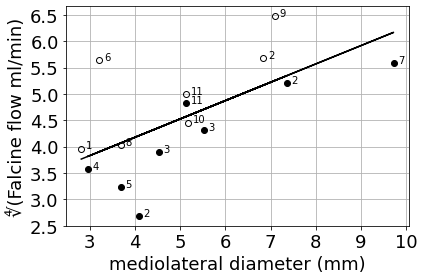

In [16]:
### Figure 2b
# Falcince:Inflow versus SS-MD. This is really abnormal
# So this is an interesting plot when compared with the normal data that goes from 100ml/min at birth to 550ml/min at 60 weeks (ref: Varela, Liu)
# abstract style, all solid
# plt.plot(T['SS-MD'], T['falcine']*60, 'ko')

# # No red/black for NAR, ALL Black
# # No NAR is black
# plt.plot(T.loc[(T['embo']==0) , 'SS-MD'], T.loc[(T['embo']==0) , 'falcine']*60, 'ko', fillstyle='none',)
# plt.plot(T.loc[(T['embo']==1) , 'SS-MD'], T.loc[(T['embo']==1) , 'falcine']*60, 'ko')

# No NAR is black
plt.plot(T.loc[(T['embo']==0) & (T['NAR']==0), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==0), 'falcine_mlmin_root'], 'ko', fillstyle='none',)
plt.plot(T.loc[(T['embo']==1) & (T['NAR']==0), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==0), 'falcine_mlmin_root'], 'ko')
# NAR is red
# plt.plot(T.loc[(T['embo']==0) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==1), 'falcine']*60, 'ro', fillstyle='none',)
# plt.plot(T.loc[(T['embo']==1) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==1), 'falcine']*60, 'ro')
plt.plot(T.loc[(T['embo']==0) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==1), 'falcine_mlmin_root'], 'ko', fillstyle='none',)
plt.plot(T.loc[(T['embo']==1) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==1), 'falcine_mlmin_root'], 'ko')

plt.xlabel('mediolateral diameter (mm)', fontsize=18)
plt.ylabel('\u221C(Falcine flow ml/min)', fontsize=18)
# plt.ylim([0, 300])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
d = np.polyfit(T['SS-MD'], T['falcine_mlmin_root'], 1)
f = np.poly1d(d)
plt.plot(T['SS-MD'], f(T['SS-MD']), 'k-')
 
for i, x in enumerate(T['ID_N']):
    if i == 0:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine_mlmin_root'][i])))
    elif i == 11:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine_mlmin_root'][i])))
    elif i == 12:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine_mlmin_root'][i])))
    else:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, T['falcine_mlmin_root'][i]))

# # M.W. second time point
# plt.plot(4.52, 3.8, 'ko', fillstyle='none')
# plt.annotate('3', (4.52+0.1, 3.8+0.1))

fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig4c_excld12.png')

                            OLS Regression Results                            
Dep. Variable:          cortical_flow   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     2.411
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.144
Time:                        09:57:15   Log-Likelihood:                -100.75
No. Observations:                  15   AIC:                             205.5
Df Residuals:                      13   BIC:                             206.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           369.1573     99.02

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


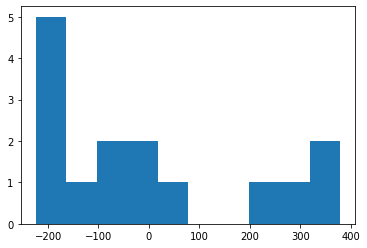

Intercept: 369.16 [155.23, 583.08] P=0.003
age_at_scan_weeks: 5.00 [-1.96, 11.96] P=0.144
W=0.87, P=0.038
                            OLS Regression Results                            
Dep. Variable:          cortical_flow   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.177
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.341
Time:                        09:57:15   Log-Likelihood:                -100.68
No. Observations:                  15   AIC:                             207.4
Df Residuals:                      12   BIC:                             209.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


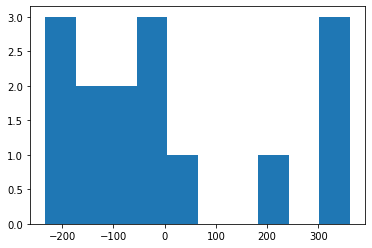

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept: 346.57 [77.55, 615.58] P=0.016
age_at_scan_weeks: 5.09 [-2.20, 12.39] P=0.154
embo: 38.01 [-213.75, 289.78] P=0.748
W=0.86, P=0.026
                            OLS Regression Results                            
Dep. Variable:          cortical_flow   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     1.845
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.197
Time:                        09:57:15   Log-Likelihood:                -98.971
No. Observations:                  15   AIC:                             205.9
Df Residuals:                      11   BIC:                             208.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      

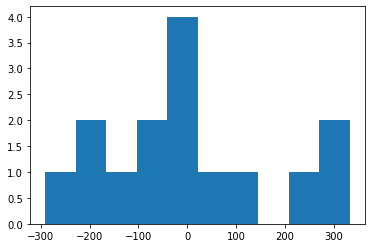

Intercept: 491.73 [175.11, 808.35] P=0.006
age_at_scan_weeks: 1.42 [-6.96, 9.81] P=0.715
embo: 21.79 [-216.12, 259.69] P=0.844
NAR: -323.04 [-746.14, 100.05] P=0.121
W=0.95, P=0.489


In [17]:
## A bit more about cortical flow:
mod = smf.ols(formula="cortical_flow ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))


mod = smf.ols(formula="cortical_flow ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="cortical_flow ~ age_at_scan_weeks + embo + NAR", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

                            OLS Regression Results                            
Dep. Variable:              SSS_mlmin   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     16.11
Date:                Thu, 15 Feb 2024   Prob (F-statistic):            0.00387
Time:                        09:57:15   Log-Likelihood:                -54.159
No. Observations:                  10   AIC:                             112.3
Df Residuals:                       8   BIC:                             112.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.7003     30.21

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


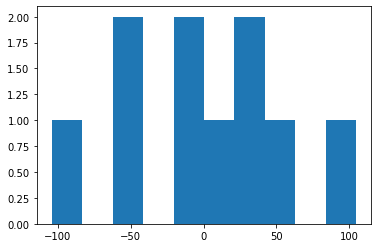

Intercept: 6.70 [-62.97, 76.37] P=0.830
age_at_scan_weeks: 4.51 [1.92, 7.10] P=0.004
W=0.98, P=0.972
                            OLS Regression Results                            
Dep. Variable:              SSS_mlmin   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     9.794
Date:                Thu, 15 Feb 2024   Prob (F-statistic):            0.00936
Time:                        09:57:16   Log-Likelihood:                -53.003
No. Observations:                  10   AIC:                             112.0
Df Residuals:                       7   BIC:                             112.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


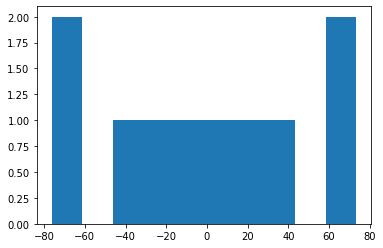

Intercept: -33.58 [-131.62, 64.47] P=0.445
age_at_scan_weeks: 5.15 [2.38, 7.91] P=0.003
embo: 54.08 [-40.70, 148.86] P=0.219
W=0.96, P=0.758
                            OLS Regression Results                            
Dep. Variable:              SSS_mlmin   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     7.441
Date:                Thu, 15 Feb 2024   Prob (F-statistic):             0.0191
Time:                        09:57:16   Log-Likelihood:                -51.916
No. Observations:                  10   AIC:                             111.8
Df Residuals:                       6   BIC:                             113.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


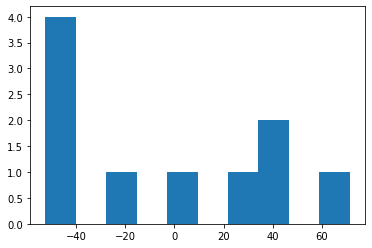

Intercept: -79.61 [-215.14, 55.92] P=0.201
age_at_scan_weeks: 6.30 [2.67, 9.93] P=0.005
embo: 70.11 [-30.32, 170.54] P=0.138
NAR: 70.17 [-72.07, 212.41] P=0.273
W=0.89, P=0.172


In [18]:
## SSS 
mod = smf.ols(formula="SSS_mlmin ~ age_at_scan_weeks", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

## So relating falcine flow to SSMD including a categorical effect of embolizaiton works really well without Labady, and with him still looks alright
mod = smf.ols(formula="SSS_mlmin ~ age_at_scan_weeks + embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

## Probably a stretch, but nearly significant
mod = smf.ols(formula="SSS_mlmin ~ age_at_scan_weeks + embo + NAR", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))



In [19]:
## I would really like to know how the MCA/PCA ratio looks

In [20]:
# Now that you have PCA flows, calc the ratio
T.keys()
T['R_PCAMCA'] = T['RPCA'] / T['RMCA']
T['L_PCAMCA'] = T['LPCA'] / T['LMCA']

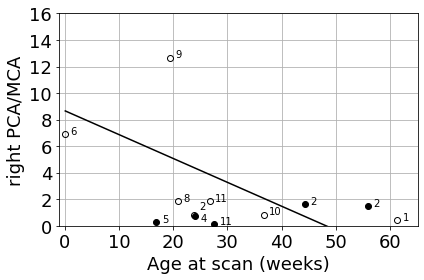

In [21]:
## RPCMCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'R_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'R_PCAMCA'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('right PCA/MCA', fontsize=18)
plt.ylim([0, 16])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
T_nan = T.dropna(subset=['R_PCAMCA']) # This wasn't plotting, becasue of nan in the SSS column
d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['R_PCAMCA'], 1)
f = np.poly1d(d)
plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if i == 1: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['R_PCAMCA'][i] + 0.4))
    elif i == 4: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['R_PCAMCA'][i] - 0.4))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['R_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig3f_excld12.png')

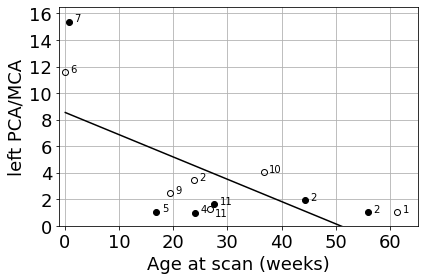

In [22]:
## LPCMCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'L_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'L_PCAMCA'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('left PCA/MCA', fontsize=18)
plt.ylim([0, 16.5])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
T_nan = T.dropna(subset=['L_PCAMCA']) # This wasn't plotting, becasue of nan in the SSS column
d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['L_PCAMCA'], 1)
f = np.poly1d(d)
plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if i == 11: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]-0.5))
    elif x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))
        
fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig3e_excld12.png')

In [23]:
T['L_PCAMCA']

0      1.048485
1      3.429185
2           NaN
3           NaN
4      0.986301
5      1.068259
6     11.590909
7     15.384615
8           NaN
9      2.441718
10     4.040984
11     1.235537
12     1.635135
13     1.954128
14     1.046053
Name: L_PCAMCA, dtype: float64

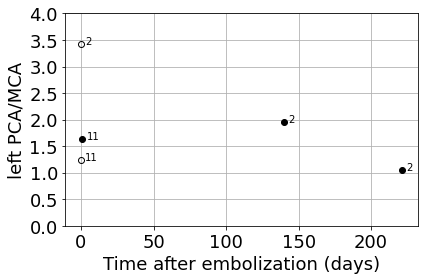

In [24]:
### PCA/MCA versus time after embo

# Falcine versus day of embo.
# So this is an interesting plot when compared with Wu et al. 2016

T_plot = T.loc[(T['ID_N']==2) | (T['ID_N']==11)].reset_index(drop=True)

plt.plot(T_plot.loc[T_plot['embo']==0, 'embo_time_days'], T_plot.loc[T_plot['embo']==0, 'L_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T_plot.loc[T_plot['embo']==1, 'embo_time_days'], T_plot.loc[T_plot['embo']==1, 'L_PCAMCA'], 'ko')

plt.xlabel('Time after embolization (days)', fontsize=18)
plt.ylabel('left PCA/MCA', fontsize=18)
plt.ylim([0, 4])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis="both")

ax1 = plt.gca()
for i, x in enumerate(T_plot['ID_N']):
    ax1.annotate('%i' % x, (T_plot['embo_time_days'][i]+3, (T_plot['L_PCAMCA'][i])))


fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig3g_excld12.png')

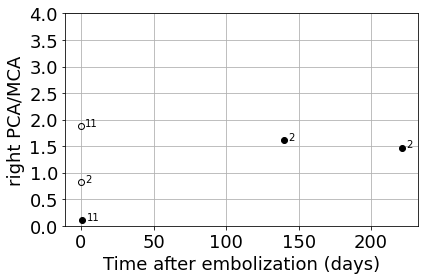

In [25]:
# Falcine versus day of embo.
# So this is an interesting plot when compared with Wu et al. 2016

T_plot = T.loc[(T['ID_N']==2) | (T['ID_N']==11)].reset_index(drop=True)

plt.plot(T_plot.loc[T_plot['embo']==0, 'embo_time_days'], T_plot.loc[T_plot['embo']==0, 'R_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T_plot.loc[T_plot['embo']==1, 'embo_time_days'], T_plot.loc[T_plot['embo']==1, 'R_PCAMCA'], 'ko')

plt.xlabel('Time after embolization (days)', fontsize=18)
plt.ylabel('right PCA/MCA', fontsize=18)
plt.ylim([0, 4])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis="both")

ax1 = plt.gca()
for i, x in enumerate(T_plot['ID_N']):
    ax1.annotate('%i' % x, (T_plot['embo_time_days'][i]+3, (T_plot['R_PCAMCA'][i])))


fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig3h_excld12.png')

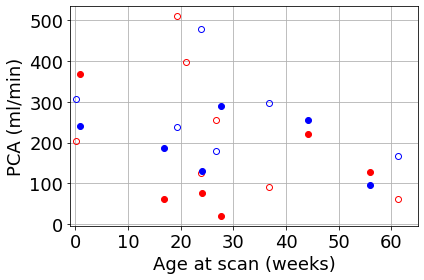

In [26]:
## PCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'RPCA']*60, 'ro', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'RPCA']*60, 'ro')

plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'LPCA']*60, 'bo', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'LPCA']*60, 'bo')

plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('PCA (ml/min)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
# f = np.poly1d(d)
# plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
# plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# # for i, x in enumerate(T['SS-MD']):
# #     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
# for i, x in enumerate(T['ID_N']):
#     if i == 11: # move it down a bit
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]-0.5))
#     elif x == 11 and i == 11:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))
#     else:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig3d_excld12.png')

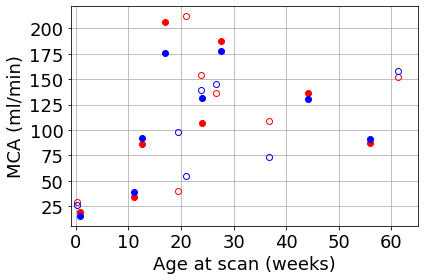

In [27]:
## PCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'RMCA']*60, 'ro', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'RMCA']*60, 'ro')

plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'LMCA']*60, 'bo', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'LMCA']*60, 'bo')

plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('MCA (ml/min)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
# f = np.poly1d(d)
# plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
# plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# # for i, x in enumerate(T['SS-MD']):
# #     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
# for i, x in enumerate(T['ID_N']):
#     if i == 11: # move it down a bit
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]-0.5))
#     elif x == 11 and i == 11:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))
#     else:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig3c_excld12.png')

                            OLS Regression Results                            
Dep. Variable:               R_PCAMCA   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     5.532
Date:                Thu, 15 Feb 2024   Prob (F-statistic):             0.0384
Time:                        09:57:16   Log-Likelihood:                -37.901
No. Observations:                  13   AIC:                             79.80
Df Residuals:                      11   BIC:                             80.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.6781      2.50

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


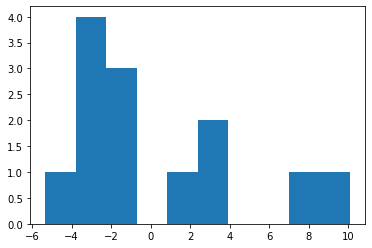

Intercept: 8.68 [3.16, 14.19] P=0.005
age_at_scan_weeks: -0.18 [-0.35, -0.01] P=0.038
W=0.88, P=0.063
                            OLS Regression Results                            
Dep. Variable:               R_PCAMCA   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     2.529
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.129
Time:                        09:57:17   Log-Likelihood:                -37.888
No. Observations:                  13   AIC:                             81.78
Df Residuals:                      10   BIC:                             83.47
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


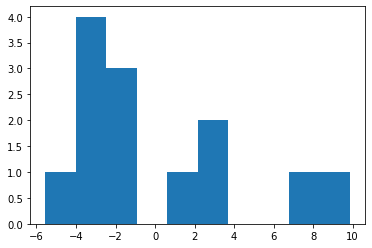

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept: 8.51 [2.05, 14.96] P=0.015
age_at_scan_weeks: -0.18 [-0.36, -0.00] P=0.048
embo: 0.40 [-5.91, 6.71] P=0.891
W=0.89, P=0.101
                            OLS Regression Results                            
Dep. Variable:               L_PCAMCA   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     8.696
Date:                Thu, 15 Feb 2024   Prob (F-statistic):             0.0146
Time:                        09:57:17   Log-Likelihood:                -31.301
No. Observations:                  12   AIC:                             66.60
Df Residuals:                      10   BIC:                             67.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025  

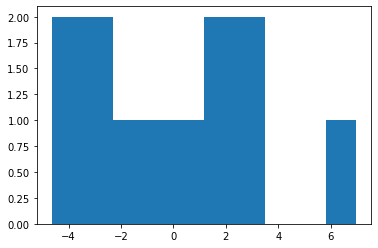

Intercept: 8.56 [4.30, 12.82] P=0.001
age_at_scan_weeks: -0.17 [-0.30, -0.04] P=0.015
W=0.94, P=0.541
                            OLS Regression Results                            
Dep. Variable:               L_PCAMCA   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     3.925
Date:                Thu, 15 Feb 2024   Prob (F-statistic):             0.0595
Time:                        09:57:17   Log-Likelihood:                -31.292
No. Observations:                  12   AIC:                             68.58
Df Residuals:                       9   BIC:                             70.04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


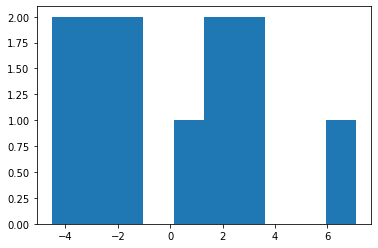

Intercept: 8.68 [3.51, 13.86] P=0.004
age_at_scan_weeks: -0.17 [-0.30, -0.03] P=0.021
embo: -0.24 [-5.20, 4.71] P=0.913
W=0.93, P=0.432
                            OLS Regression Results                            
Dep. Variable:             LMCA_mlmin   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     4.422
Date:                Thu, 15 Feb 2024   Prob (F-statistic):             0.0555
Time:                        09:57:17   Log-Likelihood:                -78.210
No. Observations:                  15   AIC:                             160.4
Df Residuals:                      13   BIC:                             161.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025 

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


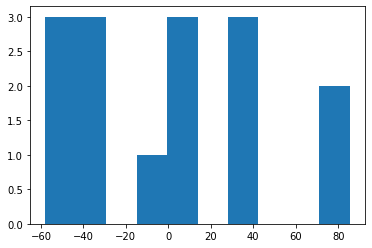

Intercept: 64.85 [17.25, 112.45] P=0.011
age_at_scan_weeks: 1.51 [-0.04, 3.06] P=0.056
W=0.92, P=0.191
                            OLS Regression Results                            
Dep. Variable:             LMCA_mlmin   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     2.180
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.156
Time:                        09:57:17   Log-Likelihood:                -78.081
No. Observations:                  15   AIC:                             162.2
Df Residuals:                      12   BIC:                             164.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


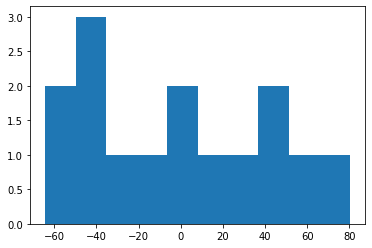

Intercept: 57.91 [-1.70, 117.52] P=0.056
age_at_scan_weeks: 1.54 [-0.08, 3.15] P=0.061
embo: 11.68 [-44.11, 67.47] P=0.656
W=0.95, P=0.528
                            OLS Regression Results                            
Dep. Variable:             RMCA_mlmin   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     2.338
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.150
Time:                        09:57:17   Log-Likelihood:                -81.858
No. Observations:                  15   AIC:                             167.7
Df Residuals:                      13   BIC:                             169.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.0

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


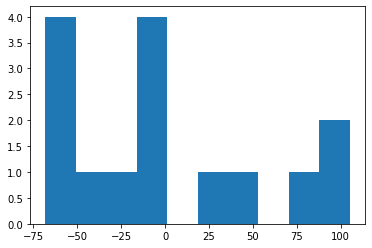

Intercept: 77.60 [16.90, 138.31] P=0.016
age_at_scan_weeks: 1.40 [-0.58, 3.37] P=0.150
W=0.90, P=0.092
                            OLS Regression Results                            
Dep. Variable:             RMCA_mlmin   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.104
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.363
Time:                        09:57:17   Log-Likelihood:                -81.831
No. Observations:                  15   AIC:                             169.7
Df Residuals:                      12   BIC:                             171.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


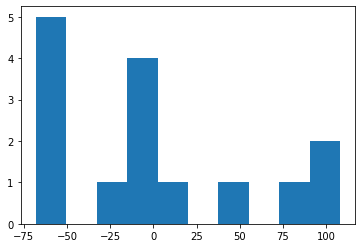

Intercept: 81.60 [5.05, 158.14] P=0.039
age_at_scan_weeks: 1.38 [-0.69, 3.46] P=0.173
embo: -6.72 [-78.36, 64.91] P=0.841
W=0.90, P=0.108
                            OLS Regression Results                            
Dep. Variable:             LPCA_mlmin   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.441
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.258
Time:                        09:57:17   Log-Likelihood:                -71.095
No. Observations:                  12   AIC:                             146.2
Df Residuals:                      10   BIC:                             147.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.02

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


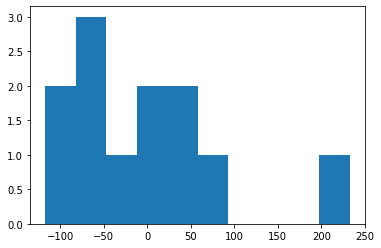

Intercept: 291.84 [174.37, 409.31] P=0.000
age_at_scan_weeks: -1.89 [-5.40, 1.62] P=0.258
W=0.90, P=0.182
                            OLS Regression Results                            
Dep. Variable:             LPCA_mlmin   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     1.797
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.220
Time:                        09:57:17   Log-Likelihood:                -69.886
No. Observations:                  12   AIC:                             145.8
Df Residuals:                       9   BIC:                             147.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


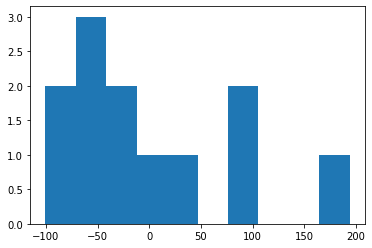

Intercept: 330.11 [201.06, 459.15] P=0.000
age_at_scan_weeks: -1.88 [-5.27, 1.52] P=0.243
embo: -77.33 [-200.77, 46.11] P=0.190
W=0.89, P=0.121
                            OLS Regression Results                            
Dep. Variable:             RPCA_mlmin   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     2.238
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.163
Time:                        09:57:17   Log-Likelihood:                -81.958
No. Observations:                  13   AIC:                             167.9
Df Residuals:                      11   BIC:                             169.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|     

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


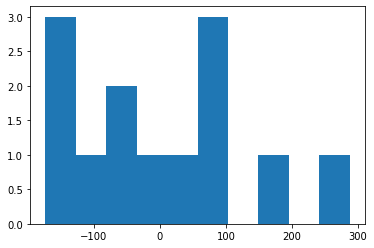

Intercept: 287.65 [124.24, 451.06] P=0.003
age_at_scan_weeks: -3.40 [-8.40, 1.60] P=0.163
W=0.94, P=0.518
                            OLS Regression Results                            
Dep. Variable:             RPCA_mlmin   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     1.700
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.231
Time:                        09:57:17   Log-Likelihood:                -81.259
No. Observations:                  13   AIC:                             168.5
Df Residuals:                      10   BIC:                             170.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


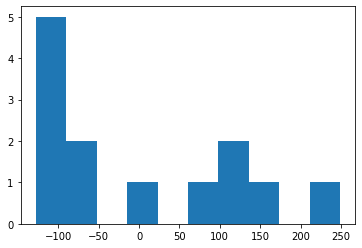

Intercept: 324.45 [142.91, 505.99] P=0.003
age_at_scan_weeks: -3.31 [-8.34, 1.72] P=0.173
embo: -84.82 [-262.22, 92.58] P=0.312
W=0.86, P=0.034


In [28]:
## For Table 2
T['LMCA_mlmin'] = T['LMCA'] * 60
T['RMCA_mlmin'] = T['RMCA'] * 60
T['LPCA_mlmin'] = T['LPCA'] * 60
T['RPCA_mlmin'] = T['RPCA'] * 60

mod = smf.ols(formula="R_PCAMCA ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="R_PCAMCA ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="L_PCAMCA ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="L_PCAMCA ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="LMCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="LMCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="RMCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="RMCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="LPCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="LPCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="RPCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="RPCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))